In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from torchmetrics import Accuracy

In [2]:
### Data Loading
from datasets import CIFAR10, get_train_loader, get_test_loader

root_dir = "/mnt/d/datasets/cifar10"
train_loader = get_train_loader(dataset=CIFAR10(root_dir, "train"), batch_size=64)
test_loader = get_test_loader(dataset=CIFAR10(root_dir, "test"), batch_size=32)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

train images: torch.Size([64, 3, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([64]), torch.int64, 0, 9
test  images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([32]), torch.int64, 0, 9


In [3]:
### Modeling

class MLP(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = in_channels
        self.linear1 = nn.Sequential(nn.Linear(32 * 32 * in_channels, 512), nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * self.in_channels)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.fc(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(in_channels=3, num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)

In [5]:
### Training

num_epochs = 10
model.train()
for epoch in range(1, num_epochs + 1):
    output_loss, output_acc = 0.0, 0.0
    total = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        total += batch_size

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        output_loss += loss.item() * batch_size
        with torch.no_grad():
            preds = torch.softmax(logits, dim=1).argmax(dim=1)
            output_acc += acc_metric(preds, labels) * batch_size

    print(f"[{epoch:2d}/{num_epochs}] loss={output_loss/total:.4f}, acc={output_acc/total:.4f}")

[ 1/10] loss=1.8371, acc=0.3331
[ 2/10] loss=1.6593, acc=0.4043
[ 3/10] loss=1.5733, acc=0.4376
[ 4/10] loss=1.5128, acc=0.4595
[ 5/10] loss=1.4721, acc=0.4719
[ 6/10] loss=1.4347, acc=0.4866
[ 7/10] loss=1.4073, acc=0.4986
[ 8/10] loss=1.3758, acc=0.5085
[ 9/10] loss=1.3517, acc=0.5173
[10/10] loss=1.3296, acc=0.5228


In [6]:
### Evaluation

model.eval()
epoch_loss, epoch_acc = 0.0, 0.0
total = 0
for batch in test_loader:
    images = batch["image"].to(device)
    labels = batch["label"].to(device)
    batch_size = images.size(0)
    total += batch_size

    logits = model(images)
    loss = loss_fn(logits, labels)

    with torch.no_grad():
        epoch_loss += loss.item() * batch_size
        preds = torch.softmax(logits, dim=1).argmax(dim=1)
        epoch_acc += acc_metric(preds, labels).item() * batch_size

print(f"loss={epoch_loss/total:.4f}, acc={epoch_acc/total:.4f}")

loss=1.4317, acc=0.4922


In [7]:
### Inference

model.eval()
all_images = []
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        logits = model(images)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)

        all_images.append(images.cpu().permute(0, 2, 3, 1).numpy())
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

    images_np = np.concatenate(all_images, axis=0)
    labels_np = np.concatenate(all_labels, axis=0)
    preds_np =  np.concatenate(all_preds, axis=0)

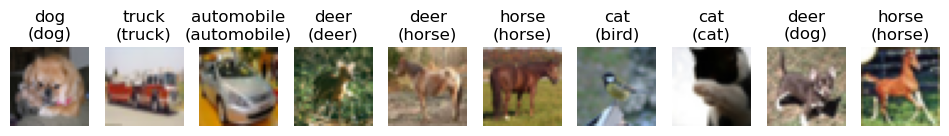

In [8]:
class_names = CIFAR10.CLASS_NAMES
num_samples = 10
indices = np.random.choice(len(images_np), size=num_samples, replace=False)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
for i, idx in enumerate(indices):
    axes[i].imshow(images_np[idx])
    axes[i].set_title(f"{class_names[preds_np[idx]]}\n({class_names[labels_np[idx]]})")
    axes[i].axis('off')

fig.tight_layout
plt.show()